<a href="https://colab.research.google.com/github/Kamruzzaman2200/Datamining/blob/main/Data_Mining_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports & simple settings

In [1]:
import os, warnings, joblib
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt

from google.colab import files

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV, learning_curve
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample

# Try to import imblearn (SMOTE). If not available we'll fallback to oversampling.
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
    print("imblearn available -> SMOTE will be used.")
except Exception:
    ImbPipeline = None
    SMOTE = None
    IMBLEARN_AVAILABLE = False
    print("imblearn NOT available -> will use random oversampling fallback.")

# Output directory
OUT_DIR = "/mnt/data/model_artifacts"
os.makedirs(OUT_DIR, exist_ok=True)
RANDOM_STATE = 42
N_JOBS = -1  # change to 1 if you run into resource limits


imblearn available -> SMOTE will be used.


#Upload dataset

In [2]:
print("Upload your CSV (e.g., cardio_train.csv) now.")
uploaded = files.upload()
if not uploaded:
    raise RuntimeError("No file uploaded.")
fname = list(uploaded.keys())[0]
CSV_PATH = "/mnt/data/" + fname
with open(CSV_PATH, "wb") as f:
    f.write(uploaded[fname])
print("Saved to:", CSV_PATH)


Upload your CSV (e.g., cardio_train.csv) now.


Saving cardio_train.csv to cardio_train.csv
Saved to: /mnt/data/cardio_train.csv


#Load CSV robustly and inspect

In [3]:
def load_csv_auto(path):
    for sep in [',',';','\t']:
        try:
            df = pd.read_csv(path, sep=sep)
            if df.shape[1] > 1:
                print(f"Loaded with sep='{sep}' -> shape={df.shape}")
                return df
        except Exception:
            continue
    return pd.read_csv(path)

df_raw = load_csv_auto(CSV_PATH)
print("Initial shape:", df_raw.shape)
display(df_raw.head())


Loaded with sep=';' -> shape=(70000, 13)
Initial shape: (70000, 13)


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


#Basic cleaning: drop id, age→years, BMI

In [4]:
df = df_raw.copy()

# Drop id-like columns
for c in ['id','ID','Id']:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# Detect target column (common names or binary 0/1 fallback)
target_col = None
for c in df.columns:
    if c.lower() in ['cardio','target','y','outcome','cardio_event','disease']:
        target_col = c; break
if target_col is None:
    # fallback: first binary 0/1 column
    for c in df.columns:
        vals = pd.Series(df[c].dropna().unique())
        if set(vals).issubset({0,1}) and df[c].nunique()<=2:
            target_col = c; break
if target_col is None:
    raise RuntimeError("Could not detect binary target column. Columns: " + ", ".join(df.columns))
print("Detected target:", target_col)
print(df[target_col].value_counts())

# Age -> years
if 'age' in df.columns:
    if df['age'].median() > 100:
        df['age_years'] = (df['age'] / 365).round().astype(int)
    else:
        df['age_years'] = df['age']
    df.drop(columns=['age'], inplace=True)

# BMI compute if possible
if 'height' in df.columns and 'weight' in df.columns and not any(c.lower()=='bmi' for c in df.columns):
    try:
        df['BMI'] = df['weight'] / ((df['height']/100)**2)
    except Exception:
        pass

# Drop constant columns (except target)
const_cols = [c for c in df.columns if df[c].nunique()<=1 and c!=target_col]
if const_cols:
    df.drop(columns=const_cols, inplace=True)
    print("Dropped constant cols:", const_cols)

print("After cleaning shape:", df.shape)
display(df.head())


Detected target: cardio
cardio
0    35021
1    34979
Name: count, dtype: int64
After cleaning shape: (70000, 13)


,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_years,BMI
0,2,168,62.0,110,80,1,1,0,0,1,0,50,21.967120
1,1,156,85.0,140,90,3,1,0,0,1,1,55,34.927679
2,1,165,64.0,130,70,3,1,0,0,0,1,52,23.507805
3,2,169,82.0,150,100,1,1,0,0,1,1,48,28.710479
4,1,156,56.0,100,60,1,1,0,0,0,0,48,23.011177


#Correlation filtering (drop highly correlated numeric features)

In [5]:
X_all = df.drop(columns=[target_col])
y_all = df[target_col].astype(int)

numeric_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_all.columns if c not in numeric_cols]

if len(numeric_cols) > 1:
    corr = X_all[numeric_cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    to_drop = [col for col in upper.columns if any(upper[col] > 0.90)]
    if to_drop:
        X_all = X_all.drop(columns=to_drop)
        numeric_cols = [c for c in numeric_cols if c not in to_drop]
        print("Dropped highly correlated numeric columns:", to_drop)
    else:
        print("No high correlations >0.90 found.")
else:
    print("Not enough numeric features to correlate-filter.")

print("Features after filtering:", X_all.shape[1])


No high correlations >0.90 found.
Features after filtering: 12


#Recompute numeric & categorical lists

In [6]:
numeric_cols = X_all.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_all.columns if c not in numeric_cols]
print("Numeric cols:", numeric_cols)
print("Categorical cols:", cat_cols)

Numeric cols: ['gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_years', 'BMI']
Categorical cols: []


#Tunable knobs: PCA & K_BEST preprocessor factory

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def make_preprocessor(use_pca=False, pca_n=5, use_kbest=False, kbest_k=5):
    num_steps = [('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())]
    if use_pca:
        pca_n = min(pca_n, max(1, len(numeric_cols)))
        num_steps.append(('pca', PCA(n_components=pca_n, random_state=RANDOM_STATE)))
    elif use_kbest:
        kbest_k = min(kbest_k, max(1, len(numeric_cols)))
        num_steps.append(('kbest', SelectKBest(score_func=f_classif, k=kbest_k)))
    num_pipe = Pipeline(num_steps)
    transformers = [('num', num_pipe, numeric_cols)]
    if len(cat_cols) > 0:
        transformers.append(('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols))
    return ColumnTransformer(transformers=transformers, remainder='drop')

pre_base = make_preprocessor(use_pca=False)
pre_pca5 = make_preprocessor(use_pca=True, pca_n=min(5, max(1, len(numeric_cols))))
pre_kbest5 = make_preprocessor(use_kbest=True, kbest_k=min(5, max(1, len(numeric_cols))))
print("Preprocessors prepared (base, pca5, kbest5)")


Preprocessors prepared (base, pca5, kbest5)


#Wrapper class so imblearn can accept pipeline as transformer

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class PipelineWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, pipeline):
        self.pipeline = pipeline
    def fit(self, X, y=None):
        if hasattr(self.pipeline, 'fit'):
            self.pipeline.fit(X, y)
        return self
    def transform(self, X):
        if hasattr(self.pipeline, 'transform'):
            return self.pipeline.transform(X)
        return X
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

# Example: wrapped_pre = PipelineWrapper(pre_base)
print("PipelineWrapper ready (used only if needed).")


PipelineWrapper ready (used only if needed).


#Create wrapped feature transformers and samplers

In [9]:
# Preprocessor wrappers (not strictly necessary but convenient)
wrapped_pre_base = PipelineWrapper(pre_base)
wrapped_pre_pca5 = PipelineWrapper(pre_pca5)

# Sampler: use SMOTE if available, otherwise None (we'll fallback to oversampling)
sampler = SMOTE(random_state=RANDOM_STATE) if IMBLEARN_AVAILABLE else None
print("Sampler:", "SMOTE" if sampler is not None else "None -> using oversampling fallback")


Sampler: SMOTE


#Build model zoo using wrapped transformers (anti-overfitting defaults)

In [10]:
model_zoo = {
    'logreg': LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear', random_state=RANDOM_STATE),
    'rf': RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=4, random_state=RANDOM_STATE, class_weight='balanced'),
    'svc': SVC(probability=True, kernel='rbf', random_state=RANDOM_STATE),
    'gb': HistGradientBoostingClassifier(max_iter=300, random_state=RANDOM_STATE),
    'mlp': MLPClassifier(hidden_layer_sizes=(64,), max_iter=600, early_stopping=True, random_state=RANDOM_STATE)
}
print("Model zoo:", list(model_zoo.keys()))


Model zoo: ['logreg', 'rf', 'svc', 'gb', 'mlp']


#Helper: random oversample fallback (keeps sampling inside training folds)

In [11]:
def random_oversample(X, y, random_state=RANDOM_STATE):
    df_tr = pd.concat([X.reset_index(drop=True), y.reset_index(drop=True)], axis=1)
    target = y.name
    counts = df_tr[target].value_counts()
    if counts.min() == counts.max():
        return X, y
    maj = counts.idxmax(); minc = counts.idxmin()
    n = counts.max()
    df_min = df_tr[df_tr[target]==minc]
    df_min_up = resample(df_min, replace=True, n_samples=n, random_state=random_state)
    df_maj = df_tr[df_tr[target]==maj]
    df_bal = pd.concat([df_maj, df_min_up]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    return df_bal.drop(columns=[target]), df_bal[target]


#Build imblearn pipelines or sklearn pipelines (depending on availability)

In [12]:
pipelines = {}
if IMBLEARN_AVAILABLE:
    from imblearn.pipeline import Pipeline as ImbPipeline
    for name, clf in model_zoo.items():
        pipelines[name] = ImbPipeline([('pre', pre_base), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', clf)])
else:
    # no imblearn -> build sklearn Pipeline and we'll oversample manually inside CV/training
    for name, clf in model_zoo.items():
        pipelines[name] = Pipeline([('pre', pre_base), ('clf', clf)])

print("Pipelines created:", list(pipelines.keys()))


Pipelines created: ['logreg', 'rf', 'svc', 'gb', 'mlp']


#Train/test split (use df_reduced)

In [13]:
X = X_all.copy(); y = y_all.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE)
print("Train/test shapes:", X_train.shape, X_test.shape)
print(y_train.value_counts())


Train/test shapes: (56000, 12) (14000, 12)
cardio
0    28017
1    27983
Name: count, dtype: int64


#CV scoring helpers (safe roc handling)

In [14]:
def compute_safe_roc(est, X, y):
    try:
        if hasattr(est, 'predict_proba'):
            probs = est.predict_proba(X)[:,1]
        elif hasattr(est, 'decision_function'):
            probs = est.decision_function(X)
        else:
            probs = est.predict(X)
        return roc_auc_score(y, probs)
    except Exception:
        return np.nan
print("safe ROC helper ready.")


safe ROC helper ready.


#Cross-validate all models (SMOTE inside pipeline if available; else oversample inside fold)

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_results = {}
print("Starting cross-validation for each model...")

for name, pipe in pipelines.items():
    print("\nCV ->", name)
    accs, f1s, rocs = [], [], []
    for train_idx, val_idx in cv.split(X_train, y_train):
        Xtr, Xval = X_train.iloc[train_idx], X_train.iloc[val_idx]
        ytr, yval = y_train.iloc[train_idx], y_train.iloc[val_idx]
        if IMBLEARN_AVAILABLE:
            try:
                pipe.fit(Xtr, ytr)
            except Exception as e:
                print("Fit failed for", name, e); accs.append(np.nan); f1s.append(np.nan); rocs.append(np.nan); continue
        else:
            Xtr_bal, ytr_bal = random_oversample(Xtr, ytr)
            try:
                pipe.fit(Xtr_bal, ytr_bal)
            except Exception as e:
                print("Fit failed for", name, e); accs.append(np.nan); f1s.append(np.nan); rocs.append(np.nan); continue
        yp = pipe.predict(Xval)
        accs.append(accuracy_score(yval, yp))
        p,r,f,_ = (classification_report(yval, yp, output_dict=True)['1']['precision'],
                   None, None, None) if False else (None,None,None,None)  # placeholder; we compute f1 below
        # compute f1 safely
        try:
            from sklearn.metrics import f1_score
            f1s.append(f1_score(yval, yp, zero_division=0))
        except Exception:
            f1s.append(np.nan)
        # ROC AUC
        try:
            if hasattr(pipe, 'predict_proba'):
                probs = pipe.predict_proba(Xval)[:,1]
            elif hasattr(pipe, 'decision_function'):
                probs = pipe.decision_function(Xval)
            else:
                probs = yp
            rocs.append(roc_auc_score(yval, probs))
        except Exception:
            rocs.append(np.nan)
    cv_results[name] = {'accuracy': np.array(accs), 'f1': np.array(f1s), 'roc_auc': np.array(rocs)}
    print(name, "mean acc:", np.nanmean(accs), "mean roc:", np.nanmean(rocs), "mean f1:", np.nanmean(f1s))


Starting cross-validation for each model...

CV -> logreg
logreg mean acc: 0.7200357142857142 mean roc: 0.7827457057651471 mean f1: 0.7082230424463885

CV -> rf
rf mean acc: 0.7348392857142857 mean roc: 0.8010996701463009 mean f1: 0.718060169375898

CV -> svc
svc mean acc: 0.7261785714285715 mean roc: 0.7859359175757885 mean f1: 0.7171666349905499

CV -> gb
gb mean acc: 0.7365178571428572 mean roc: 0.8028070304730633 mean f1: 0.7254448798780839

CV -> mlp
mlp mean acc: 0.7298571428571428 mean roc: 0.7919368031270129 mean f1: 0.7256894122717321


#Short RandomizedSearchCV for RandomForest & SVC (to get tuned estimators)

In [18]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

tuned_models = {}

# Prepare training set for RandomizedSearch: pipelines handle SMOTE if available;
# if not available we'll supply oversampled X_train/y_train to the search's fit.
if IMBLEARN_AVAILABLE:
    X_for_search, y_for_search = X_train, y_train
else:
    X_for_search, y_for_search = random_oversample(X_train, y_train)

# RandomForest
if IMBLEARN_AVAILABLE:
    rf_pipe = ImbPipeline([('pre', pre_base), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
else:
    # use sklearn pipeline if imblearn not present
    rf_pipe = Pipeline([('pre', pre_base), ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])

rf_params = {'clf__n_estimators': [100,200,300], 'clf__max_depth': [4,6,8,None], 'clf__min_samples_leaf':[1,2,4]}
try:
    rs_rf = RandomizedSearchCV(rf_pipe, rf_params, n_iter=8, cv=3, scoring='roc_auc', n_jobs=N_JOBS, random_state=RANDOM_STATE)
    rs_rf.fit(X_for_search, y_for_search)
    tuned_models['rf'] = rs_rf.best_estimator_
    print("RF tuned best score:", rs_rf.best_score_)
except Exception as e:
    print("RF RandomizedSearch failed:", e)

# SVC
if IMBLEARN_AVAILABLE:
    svc_pipe = ImbPipeline([('pre', pre_base), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', SVC(probability=True, random_state=RANDOM_STATE))])
else:
    svc_pipe = Pipeline([('pre', pre_base), ('clf', SVC(probability=True, random_state=RANDOM_STATE))])

svc_params = {'clf__C':[0.1,1,5], 'clf__kernel':['rbf','poly']}
try:
    rs_svc = RandomizedSearchCV(svc_pipe, svc_params, n_iter=6, cv=3, scoring='roc_auc', n_jobs=N_JOBS, random_state=RANDOM_STATE)
    rs_svc.fit(X_for_search, y_for_search)
    tuned_models['svc'] = rs_svc.best_estimator_
    print("SVC tuned best score:", rs_svc.best_score_)
except Exception as e:
    print("SVC RandomizedSearch failed:", e)

RF tuned best score: 0.8009871065155836
SVC tuned best score: 0.7877895936070196


#Evaluate tuned models on test set (safe ROC handling)

In [19]:
eval_rows = []
for name, est in tuned_models.items():
    try:
        # Refit on full training set (SMOTE inside pipeline if available)
        if IMBLEARN_AVAILABLE:
            est.fit(X_train, y_train)
        else:
            Xtr_bal, ytr_bal = random_oversample(X_train, y_train)
            est.fit(Xtr_bal, ytr_bal)
        yp = est.predict(X_test)
        if hasattr(est, 'predict_proba'):
            probs = est.predict_proba(X_test)[:,1]
        elif hasattr(est, 'decision_function'):
            probs = est.decision_function(X_test)
        else:
            probs = yp
        auc = roc_auc_score(y_test, probs)
        acc = accuracy_score(y_test, yp)
        print(f"\n{name} -> acc: {acc:.4f}, roc_auc: {auc:.4f}")
        print("Confusion:\n", confusion_matrix(y_test, yp))
        print("Report:\n", classification_report(y_test, yp, zero_division=0))
        eval_rows.append({'model':name, 'accuracy':acc, 'roc_auc':auc})
    except Exception as e:
        print("Evaluation failed for", name, e)

eval_df = pd.DataFrame(eval_rows).sort_values('roc_auc', ascending=False).reset_index(drop=True)
print("\nTuned evaluation summary:")
display(eval_df)


rf -> acc: 0.7317, roc_auc: 0.7962
Confusion:
 [[5531 1473]
 [2283 4713]]
Report:
               precision    recall  f1-score   support

           0       0.71      0.79      0.75      7004
           1       0.76      0.67      0.72      6996

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000


svc -> acc: 0.7282, roc_auc: 0.7848
Confusion:
 [[5280 1724]
 [2081 4915]]
Report:
               precision    recall  f1-score   support

           0       0.72      0.75      0.74      7004
           1       0.74      0.70      0.72      6996

    accuracy                           0.73     14000
   macro avg       0.73      0.73      0.73     14000
weighted avg       0.73      0.73      0.73     14000


Tuned evaluation summary:


,model,accuracy,roc_auc
0,rf,0.731714,0.796159
1,svc,0.728214,0.784849


#stacking ensemble and soft voting ensemble (before/after tuning)

In [20]:
# Build stacking from top CV models (use pipelines dict)
cv_scores = {name: np.nanmean(vals['roc_auc']) for name, vals in cv_results.items()}
cv_sorted = sorted(cv_scores.items(), key=lambda x: x[1], reverse=True)
top_models = [name for name,_ in cv_sorted[:3]]

estimators = []
for m in top_models:
    # ensure pipeline fitted on full train
    try:
        if IMBLEARN_AVAILABLE:
            pipelines[m].fit(X_train, y_train)
        else:
            Xtr_bal, ytr_bal = random_oversample(X_train, y_train)
            pipelines[m].fit(Xtr_bal, ytr_bal)
        estimators.append((m, pipelines[m]))
    except Exception:
        continue

if len(estimators) >= 2:
    stack = StackingClassifier(estimators=estimators[:3], final_estimator=LogisticRegression(max_iter=1000), cv=3, n_jobs=N_JOBS)
    stack.fit(X_train, y_train)
    sp = stack.predict_proba(X_test)[:,1]
    print("Stack ROC AUC:", roc_auc_score(y_test, sp))
    joblib.dump(stack, os.path.join(OUT_DIR, 'stacking_pre_tune.pkl'))
else:
    print("Not enough base estimators for stacking.")

# Soft voting ensemble
if len(estimators) >= 2:
    voters = [(name, est) for name, est in estimators]
    vote = VotingClassifier(estimators=voters, voting='soft', n_jobs=N_JOBS)
    vote.fit(X_train, y_train)
    vp = vote.predict_proba(X_test)[:,1]
    print("Voting ROC AUC:", roc_auc_score(y_test, vp))
    joblib.dump(vote, os.path.join(OUT_DIR, 'voting_pre_tune.pkl'))
else:
    print("Not enough voters for voting.")


Stack ROC AUC: 0.7993176385526983
Voting ROC AUC: 0.7981945973696644


#media pipe (diagnostic preprocessor save)

In [21]:
# Diagnostic: fit preprocessor and show transformed shape, save preprocessor
pre_base.fit(X_train)
try:
    Xtr_trans = pre_base.transform(X_train)
    print("Preprocessor transform shape:", getattr(Xtr_trans, "shape", None))
except Exception as e:
    print("Preprocessor transform failed:", e)
joblib.dump(pre_base, os.path.join(OUT_DIR, 'preprocessor_base.pkl'))


Preprocessor transform shape: (56000, 12)


['/mnt/data/model_artifacts/preprocessor_base.pkl']

#perceptron layer (MLP) training & evaluation

In [22]:
mlp_pipe = None
if IMBLEARN_AVAILABLE:
    mlp_pipe = ImbPipeline([('pre', pre_base), ('smote', SMOTE(random_state=RANDOM_STATE)), ('clf', model_zoo['mlp'])])
else:
    mlp_pipe = Pipeline([('pre', pre_base), ('clf', model_zoo['mlp'])])

# Fit MLP (oversampling if imblearn not present)
if IMBLEARN_AVAILABLE:
    mlp_pipe.fit(X_train, y_train)
else:
    Xtr_bal, ytr_bal = random_oversample(X_train, y_train)
    mlp_pipe.fit(Xtr_bal, ytr_bal)

yp = mlp_pipe.predict(X_test)
probs = mlp_pipe.predict_proba(X_test)[:,1] if hasattr(mlp_pipe, 'predict_proba') else mlp_pipe.decision_function(X_test)
print("MLP test acc:", accuracy_score(y_test, yp), "roc_auc:", roc_auc_score(y_test, probs))
joblib.dump(mlp_pipe, os.path.join(OUT_DIR, 'pipeline_mlp.pkl'))


MLP test acc: 0.7255 roc_auc: 0.7887776351110645


['/mnt/data/model_artifacts/pipeline_mlp.pkl']

#Learning curve for best model (pick tuned or stacking)

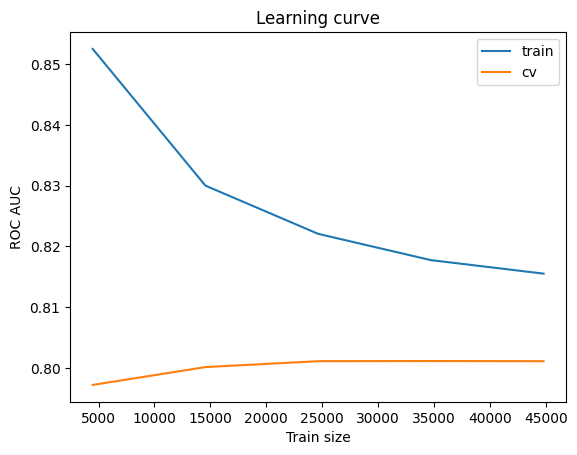

In [23]:
from sklearn.model_selection import learning_curve

# pick best candidate
candidate = None
if not eval_df.empty:
    candidate = eval_df.iloc[0]['model']
    if candidate in tuned_models:
        candidate_est = tuned_models[candidate]
    else:
        candidate_est = None
elif 'stack' in globals():
    candidate_est = stack
else:
    candidate_est = list(pipelines.values())[0]

if candidate_est is not None:
    try:
        train_sizes, train_scores, test_scores = learning_curve(candidate_est, X_train, y_train, cv=5, scoring='roc_auc', n_jobs=N_JOBS, train_sizes=np.linspace(0.1,1.0,5))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), label='train')
        plt.plot(train_sizes, np.mean(test_scores, axis=1), label='cv')
        plt.xlabel("Train size"); plt.ylabel("ROC AUC"); plt.title("Learning curve"); plt.legend(); plt.show()
    except Exception as e:
        print("Learning curve failed:", e)
else:
    print("No candidate for learning curve.")


#ROC curves for tuned models & mlp & stacking

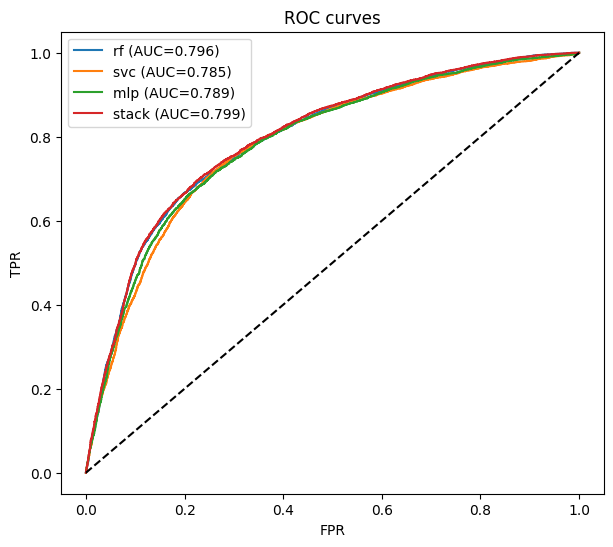

In [24]:
plt.figure(figsize=(7,6))
plotted = 0
candidates = []
if 'tuned_models' in globals():
    candidates += list(tuned_models.keys())
if 'mlp_pipe' in globals():
    candidates.append('mlp')
if 'stack' in globals():
    candidates.append('stack')

for name in candidates:
    try:
        if name == 'mlp':
            est = mlp_pipe
        elif name == 'stack':
            est = stack
        else:
            est = tuned_models.get(name)
        if est is None:
            continue
        if hasattr(est, 'predict_proba'):
            probs = est.predict_proba(X_test)[:,1]
        elif hasattr(est, 'decision_function'):
            probs = est.decision_function(X_test)
        else:
            continue
        fpr, tpr, _ = roc_curve(y_test, probs)
        auc = roc_auc_score(y_test, probs)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        plotted += 1
    except Exception:
        continue

if plotted > 0:
    plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC curves'); plt.legend(); plt.show()
else:
    print("No ROC curves plotted.")


#Save artifacts (CSV + pickled models)

In [25]:
# Save summaries
try:
    cv_summary = pd.DataFrame([{ 'model':k, 'mean_roc':np.nanmean(v['roc_auc']), 'mean_acc':np.nanmean(v['accuracy']) } for k,v in cv_results.items()])
    cv_summary.to_csv(os.path.join(OUT_DIR, 'cv_summary.csv'), index=False)
except Exception:
    pass

if 'eval_df' in globals() and not eval_df.empty:
    eval_df.to_csv(os.path.join(OUT_DIR, 'eval_tuned.csv'), index=False)

# Save tuned models and pipelines
for k, m in tuned_models.items():
    try:
        joblib.dump(m, os.path.join(OUT_DIR, f"tuned_{k}.pkl"))
    except Exception:
        pass

for name, p in pipelines.items():
    try:
        joblib.dump(p, os.path.join(OUT_DIR, f"pipeline_{name}.pkl"))
    except Exception:
        pass

if 'mlp_pipe' in globals():
    joblib.dump(mlp_pipe, os.path.join(OUT_DIR, 'pipeline_mlp.pkl'))
if 'stack' in globals():
    joblib.dump(stack, os.path.join(OUT_DIR, 'stacking_pre_tune.pkl'))
if 'vote' in globals():
    joblib.dump(vote, os.path.join(OUT_DIR, 'voting_pre_tune.pkl'))

# Save splits
X_train.to_csv(os.path.join(OUT_DIR,'X_train.csv'), index=False)
X_test.to_csv(os.path.join(OUT_DIR,'X_test.csv'), index=False)
y_train.to_csv(os.path.join(OUT_DIR,'y_train.csv'), index=False)
y_test.to_csv(os.path.join(OUT_DIR,'y_test.csv'), index=False)

print("Saved artifacts to", OUT_DIR)
print(os.listdir(OUT_DIR))


Saved artifacts to /mnt/data/model_artifacts
['tuned_svc.pkl', 'cv_summary.csv', 'preprocessor_base.pkl', 'voting_pre_tune.pkl', 'tuned_rf.pkl', 'pipeline_rf.pkl', 'stacking_pre_tune.pkl', 'pipeline_svc.pkl', 'X_train.csv', 'y_train.csv', 'eval_tuned.csv', 'y_test.csv', 'pipeline_logreg.pkl', 'pipeline_gb.pkl', 'pipeline_mlp.pkl', 'X_test.csv']
